# DATA 601 Final Project Report
## Team ZEM:
* <b>ZULIHUMAER HAILAITI<b/>
* <b>Maciej Pecak<b/>
* <b>Ewa Rambally<b/>

## INTRODUCTION 

Despite Canada’s status as a top economic performer of all G7 countries in 2006, it continues to experience a nationwide homelessness crisis and affordable housing shortage1. Approximately 235,000 Canadians experience homelessness each year. The number of homeless people, and the length of time they spend homeless, continues to rise. 

There may be many factors that lead to homelessness and the homelessness rate itself may also cause some social issues. Our goal of this project is to visualize the changes in occupancy in homeless emergency shelters in Calgary over the years from 2013 to 2022 and find the relationship between the occupancy of homeless shelters and several factors, including economic, weather (only years 2019 and 2021 – daily data), and crime rate. Therefore, by guidance of those data, the government or related associations can take actions to help those who have nowhere to stay as well as to increase social stability. 

## DATA SOURCES 

Data that is going to be used for exploratory analysis and visualization comes from publicly available datasets provided by the Government of Alberta and the City of Calgary.  

The dataset shared between different problems that are to be addressed contains information about homeless shelter occupancy in Alberta. It is a single csv file that comes from the Government of Alberta website:<br>
https://open.alberta.ca/opendata/funded-emergency-shelters-daily-occupancy-ab

The dataset containing macroeconomic data is provided by the Government of Alberta. Each metric is stored in a single csv that come from the following websites:<br>
https://economicdashboard.alberta.ca/unemployment <br>
https://economicdashboard.alberta.ca/AverageWeeklyEarnings<br>

The dataset containing weather data for Calgary is publicly available on Alberta Climate Information Services website. The file contains daily data and comes from the following website:<br>
https://acis.alberta.ca/acis/township-data-viewer.jsp

The dataset containing crime data for Calgary is publicly available on The Open Data Portal of the City of Calgary. The file contains monthly aggregated crime data. It is stored in a single csv that comes from the following website:<br>
https://data.calgary.ca/Health-and-Safety/Community-Crime-Statistics/78gh-n26t/data

## Problem 1 - Rate of Occupation of Homeless Shelters in Calgary by location

#### Importance: Determining where the homeless shelters should be located now and in the future. 
#### Guiding Questions:
* How does the Rate of Occupancy of Homeless Shelters in Calgary depend on location? 
* How does the occupancy or occupancy rate change in time by shelters’ location?

#### Data wrangling:
* Filter out the occupancy shelter data frame to only have Calgary data.
* Manually fill the one missing value based on the initial anaysis (2022-04-01, Capacity of Brendas House is filled based on its Capacity in the previous and later days. It stays at the same level for the previous three and the next three days).
* Convert Capacity and Overnight (Admissions) columns to integer.
* Filter only those Shelters that have positive Capacity.
* Filter only years 2019 and 2021.
* Group the data by month and day and sum up Capacity and Overnight for all shelters
* Compute the Occupancy Rates by dividing the summed up Overnight Admissions by the summed up Capacity.

In [1]:
%load_ext lab_black

ModuleNotFoundError: No module named 'lab_black'

In [1]:
import json
import re
import urllib.request

import pandas as pd
#import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from datetime import datetime, timedelta
from sklearn import linear_model
from bs4 import BeautifulSoup, NavigableString
#from geopy.geocoders import Nominatim
from scipy import stats

In [2]:
shelter_df = pd.read_csv(
    "data/2013-2022-emergency-shelter-occupancy-machine-readable.csv",
    parse_dates=["Date"],
)

# manually add the missing value for the Brenda House 2022-04-01 capacity
shelter_df.loc[
    (shelter_df["Date"] == "2022-04-01")
    & (shelter_df["ShelterName"] == "Brendas House"),
    "Capacity",
] = 60
shelter_df = shelter_df[shelter_df["City"] == "Calgary"]
shelter_df = shelter_df.astype({"Capacity": "int32", "Overnight": "int32"})
shelter_df = shelter_df.loc[shelter_df["Capacity"] > 0]

shelter_df_2019 = shelter_df.loc[shelter_df["YEAR"] == 2019]
shelter_df_2019.drop(shelter_df_2019.columns[[8]], axis=1, inplace=True)
shelter_df_2019 = shelter_df_2019.groupby("ShelterName").sum(["Capacity", "Overnight"])
shelter_df_2019["occupancy_rate"] = (
    shelter_df_2019["Overnight"] / shelter_df_2019["Capacity"]
)

shelter_df_2021 = shelter_df[shelter_df["YEAR"] == 2021]
shelter_df_2021.drop(shelter_df_2021.columns[[8]], axis=1, inplace=True)
shelter_df_2021 = shelter_df_2021.groupby("ShelterName").sum(["Capacity", "Overnight"])
shelter_df_2021["occupancy_rate"] = (
    shelter_df_2021["Overnight"] / shelter_df_2021["Capacity"]
)

C:\Users\Testing5\AppData\Local\Temp\ipykernel_7632\2939827456.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  shelter_df = pd.read_csv(
C:\Users\Testing5\AppData\Local\Temp\ipykernel_7632\2939827456.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shelter_df_2019.drop(shelter_df_2019.columns[[8]], axis=1, inplace=True)
C:\Users\Testing5\AppData\Local\Temp\ipykernel_7632\2939827456.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shelter_df_2021.drop(shelter_df_2021.columns[[8]], axis=1, inplace=True)


In [3]:
df_occupancyrate_2019 = shelter_df_2019.sort_values(
    by="occupancy_rate", ascending=False
)["occupancy_rate"]
df_occupancyrate_2021 = shelter_df_2021.sort_values(
    by="occupancy_rate", ascending=False
)["occupancy_rate"]

#### Data Visualisations

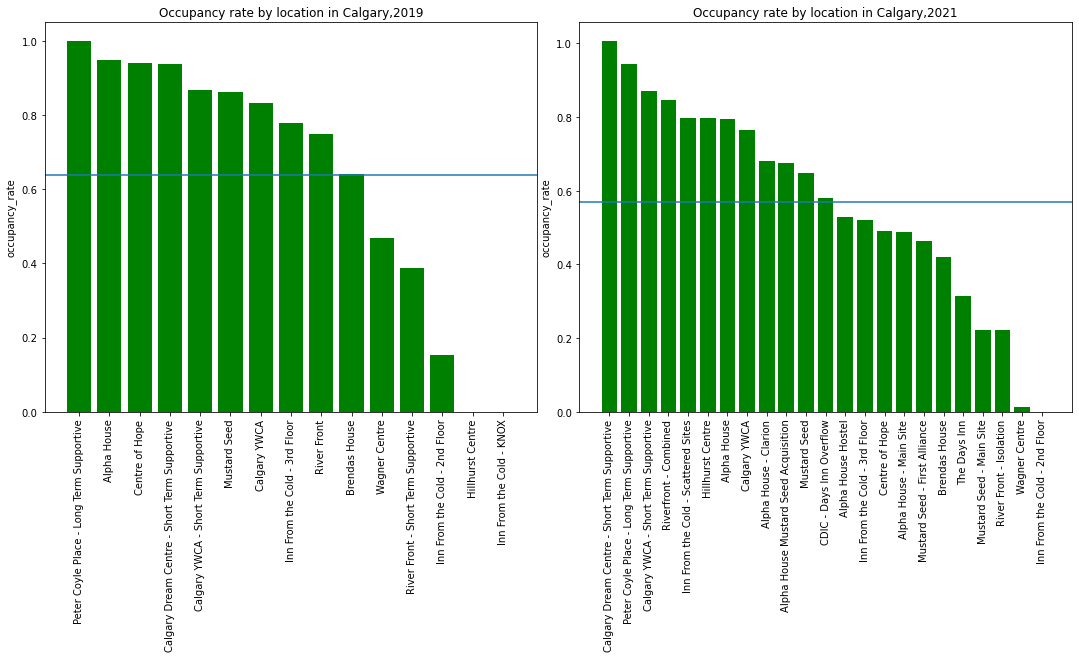

In [4]:
# Barplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.tight_layout(h_pad=25)
ax[0].bar(df_occupancyrate_2019.index, df_occupancyrate_2019, color="g")
ax[0].set_xticks(df_occupancyrate_2019.index, rotation=90)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].set_title("Occupancy rate by location in Calgary,2019")
ax[0].set_ylabel("occupancy_rate")
ax[1].bar(df_occupancyrate_2021.index, df_occupancyrate_2021, color="g")
ax[1].set_xticks(df_occupancyrate_2021.index, rotation=90)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].set_title("Occupancy rate by location in Calgary,2021")
ax[1].set_ylabel("occupancy_rate")

mean = shelter_df_2019["occupancy_rate"].mean()
ax[0].axhline(mean)

mean = shelter_df_2021["occupancy_rate"].mean()
ax[1].axhline(mean)

Based on the above two bar plots there are a few conclusions:
* There are more emergency shelters available in 2021 in comparison with 2019.
* It can be observed that more shelters were opened and the average occupancy rate slightly dropped.
* Occupancy Rate for Peter Coyle Place stayed in the same, high level in both years.
* Calgary Dream Centre stayed in top 5 most occupied shelters in both years.

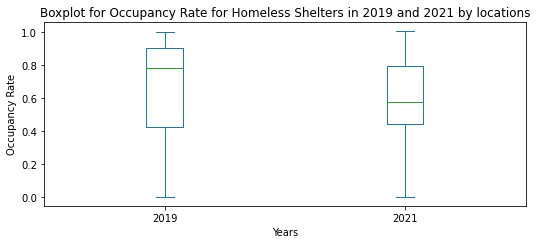

In [5]:
# boxplot
# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame(
    {
        "2019": df_occupancyrate_2019.reset_index()["occupancy_rate"],
        "2021": df_occupancyrate_2021.reset_index()["occupancy_rate"],
    }
)

# Plot the dataframe
ax = data[["2019", "2021"]].plot(kind="box", title="boxplot")

# Display the plot
ax.set_title(
    "Boxplot for Occupancy Rate for Homeless Shelters in 2019 and 2021 by locations"
)
ax.set_xlabel("Years")
ax.set_ylabel("Occupancy Rate")

plt.show()

Based on the above:
* The median of occupancy rate decreased similarly to the mean as shown on the previous graph.
* There is a decrease in the IQR spread from 2019 to 2021.

#### Timeseries plots for top 5 emergency shelters in Calgary

In [6]:
shelter_df_top5_prep = shelter_df.loc[shelter_df["City"] == "Calgary"]
shelter_df_top5_prep.drop(
    shelter_df_top5_prep[shelter_df_top5_prep["ShelterType"] == "DaytimeShelter"].index,
    inplace=True,
)
shelter_df_top5_prep = shelter_df_top5_prep.astype(
    {"Capacity": "int32", "Overnight": "int32"}
)
shelter_df_top5_prep = shelter_df_top5_prep.groupby(["YEAR", "ShelterName"]).sum(
    ["Capacity"]
)

# select top 5 shelters by summed up yearly Capacity
df_top5 = (
    shelter_df_top5_prep.reset_index()
    .sort_values("Capacity", ascending=False)
    .groupby("YEAR")
    .head(5)
    .sort_values("YEAR", ascending=False)
)

df_top5.loc[:, ["YEAR", "ShelterName", "Capacity", "Overnight"]]
df_top5 = df_top5.set_index(["YEAR", "ShelterName"]).loc[:, []]

In [7]:
shelter_df_calgary = shelter_df[shelter_df["City"] == "Calgary"]
shelter_df_calgary = shelter_df_calgary.set_index(["YEAR", "ShelterName"])

In [8]:
# by using inner join we only keep data about the top 5 largest shelters
joined_df = shelter_df_calgary.join(df_top5, on=["YEAR", "ShelterName"], how="inner")

#### Data Visualisation

In [9]:
all_years = joined_df.reset_index()
all_years = all_years.loc[:, ["YEAR", "MONTH", "ShelterName", "Capacity", "Overnight"]]
all_years["occupancy_rate"] = all_years["Overnight"] / all_years["Capacity"]

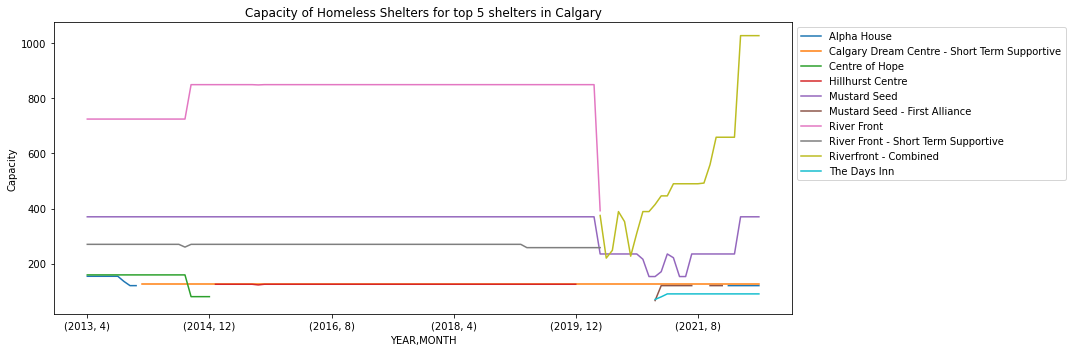

In [10]:
all_years.groupby(["YEAR", "MONTH", "ShelterName"]).mean("Capacity")[
    "Capacity"
].reset_index().pivot(
    index=["YEAR", "MONTH"], columns="ShelterName", values="Capacity"
).plot(
    figsize=(15, 5)
).legend(
    bbox_to_anchor=(1, 1)
)
plt.ylabel("Capacity")
plt.title("Capacity of Homeless Shelters for top 5 shelters in Calgary")
plt.show()

Based on the above time series graph, we can clearly see the drop in the total capacity in the first half of 2020. However, it gradually recovered to the pre-pandemic levels in the latter part of 2021.

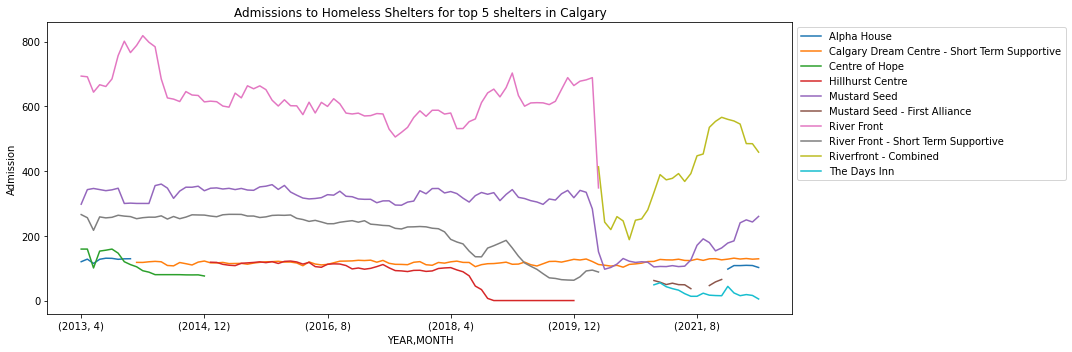

In [11]:
all_years.groupby(["YEAR", "MONTH", "ShelterName"]).mean("Overnight")[
    "Overnight"
].reset_index().pivot(
    index=["YEAR", "MONTH"], columns="ShelterName", values="Overnight"
).plot(
    figsize=(15, 5)
).legend(
    bbox_to_anchor=(1, 1)
)
plt.ylabel("Admission")
plt.title("Admissions to Homeless Shelters for top 5 shelters in Calgary")
plt.show()

Based on the above, the admissions dropped significantly when the COVID-19 pandemic started. One of the reasons might be the social distancing policies introduced to the shelters. Before the pandemic the admission to homeless shelters in Calgary was approximately at the same level.

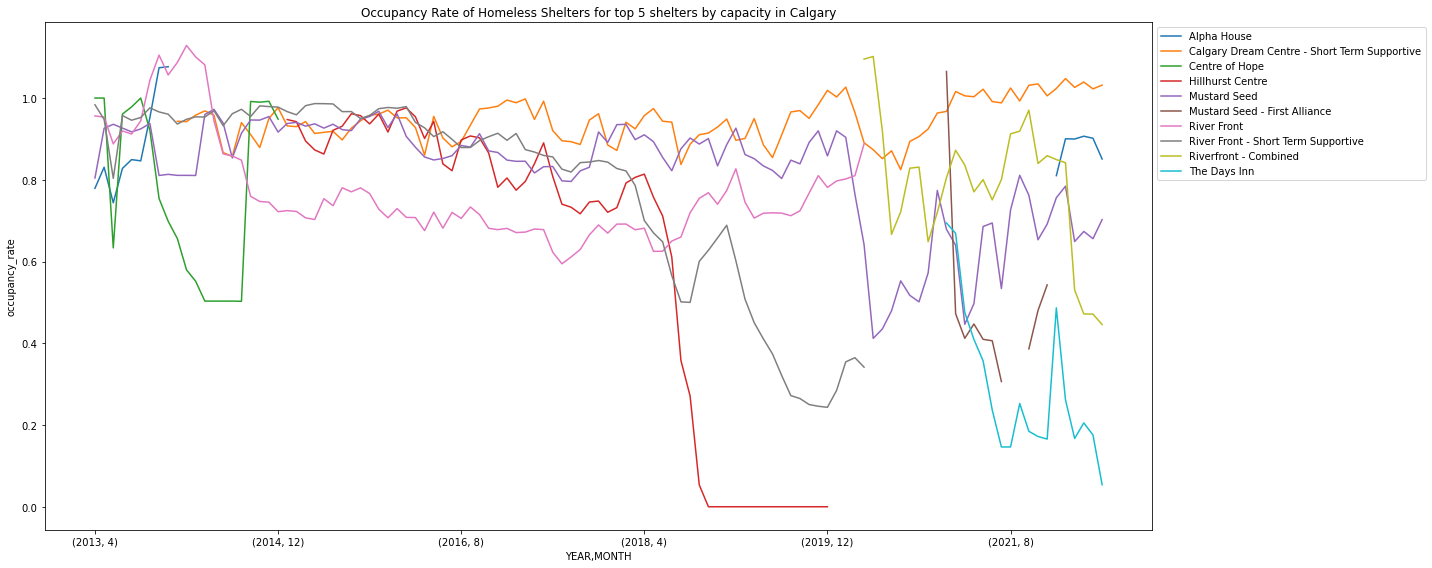

In [12]:
all_years.groupby(["YEAR", "MONTH", "ShelterName"]).mean("occupancy_rate")[
    "occupancy_rate"
].reset_index().pivot(
    index=["YEAR", "MONTH"], columns="ShelterName", values="occupancy_rate"
).plot(
    figsize=(20, 8)
).legend(
    bbox_to_anchor=(1, 1)
)
plt.ylabel("occupancy_rate")
plt.title("Occupancy Rate of Homeless Shelters for top 5 shelters by capacity in Calgary")
plt.show()

On the above graph, we can see that the occupancy rated quickly recovered after the initial impact of the pandemic. Additionally, Calgary Dreams Centre appears to be constantly in the top 5 largest shelters, while other shelters do not mainatain the same high capacity.

## Problem 2 - Rate of occupancy of Homeless Shelters in Calgary by provider

#### Importance: Determining which homeless shelters (if any) are preferred. This can open a path to determining factors of shelter quality and how they are fulfilled by shelter providers, and further determining shelter standards that attract occupancy and minimize homeless people on the streets. 
#### Guiding Questions:
* Does the Rate of Occupation of Homeless Shelters in Calgary depend on provider? 
* How does occupancy or occupancy rate change in time by provider?

#### Data wrangling:
* Filter out the occupancy shelter data frame to only have Calgary data.
* Manually fill the one missing value based on the initial anaysis (2022-04-01, Capacity of Brendas House is filled based on its Capacity in the previous and later days. It stays at the same level for the previous three and the next three days).
* Convert Capacity and Overnight (Admissions) columns to integer.
* Filter only those Shelters that have positive Capacity.
* Categorize the emergency shelter type by the website information (done manually).
* Compute the Occupancy Rates by dividing the Overnight Admissions by the Capacity.

In [13]:
shelter_df = pd.read_csv(
    "data/2013-2022-emergency-shelter-occupancy-machine-readable.csv",
    parse_dates=["Date"],
)
shelter_df = shelter_df.loc[
    shelter_df["City"] == "Calgary",
    [
        "ShelterType",
        "ShelterName",
        "Organization",
        "Shelter",
        "Capacity",
        "Overnight",
        "Date",
    ],
]

# manually add the missing value for the Brenda House 2022-04-01 capacity
shelter_df.loc[
    (shelter_df["Date"] == "2022-04-01")
    & (shelter_df["ShelterName"] == "Brendas House"),
    "Capacity",
] = 60
shelter_df.set_index("Date", inplace=True)
shelter_df = shelter_df.astype({"Capacity": "int32", "Overnight": "int32"})
shelter_df = shelter_df.loc[shelter_df["Capacity"] > 0]


C:\Users\Testing5\AppData\Local\Temp\ipykernel_7632\1091983613.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  shelter_df = pd.read_csv(


In [14]:
org_type = {
    "Calgary Drop-In Centre": "public",
    "Calgary Salvation Army": "religious",
    "Alpha House": "private",
    "Mustard Seed Calgary": "religious",
    "Calgary Dream Centre": "charitable",
    "Calgary YWCA": "charitable",
    "Peter Coyle Place": "charitable",
    "Inn from the Cold": "charitable",
    "Brendas House": "charitable",
    "The Alex": "charitable",
}

In [15]:
categories_df = shelter_df.reset_index()
categories_df = categories_df.loc[(categories_df["Date"].dt.year == 2019) & (categories_df["Date"].dt.month == 12)]
categories_df = categories_df.groupby(["ShelterName"]).mean("Capacity").reset_index()[["ShelterName", "Capacity"]]

categories_df = categories_df.set_index("ShelterName") \
    .join(shelter_df.set_index("ShelterName"), how="left", lsuffix="a", rsuffix="b") \
    .drop_duplicates(subset=["Capacitya", "Organization"])[["Capacitya", "Organization"]]

categories_df["organization_category"] = categories_df["Organization"].map(
    lambda x: org_type[x]
)
categories_df["City"] = "Calgary"
categories_df = categories_df.reset_index()
categories_df

,ShelterName,Capacitya,Organization,organization_category,City
0,Alpha House,120.0,Alpha House,private,Calgary
1,Brendas House,60.0,Brendas House,charitable,Calgary
2,Calgary Dream Centre - Short Term Supportive,125.0,Calgary Dream Centre,charitable,Calgary
3,Calgary YWCA,10.0,Calgary YWCA,charitable,Calgary
4,Calgary YWCA - Short Term Supportive,80.0,Calgary YWCA,charitable,Calgary
5,Centre of Hope,80.0,Calgary Salvation Army,religious,Calgary
6,Hillhurst Centre,125.0,Calgary Drop-In Centre,public,Calgary
7,Inn From the Cold - 2nd Floor,40.0,Inn from the Cold,charitable,Calgary
8,Inn From the Cold - 3rd Floor,80.0,Inn from the Cold,charitable,Calgary
9,Mustard Seed,370.0,Mustard Seed Calgary,religious,Calgary


{'Calgary': {'private': {'Alpha House': 120.0}, 'charitable': {'Brendas House': 60.0, 'Calgary Dream Centre - Short Term Supportive': 125.0, 'Calgary YWCA': 10.0, 'Calgary YWCA - Short Term Supportive': 80.0, 'Inn From the Cold - 2nd Floor': 40.0, 'Inn From the Cold - 3rd Floor': 80.0, 'Peter Coyle Place - Long Term Supportive': 68.0}, 'religious': {'Centre of Hope': 80.0, 'Mustard Seed': 370.0, 'Wagner Centre': 12.0}, 'public': {'Hillhurst Centre': 125.0, 'River Front': 850.0, 'River Front - Short Term Supportive': 258.0}}}


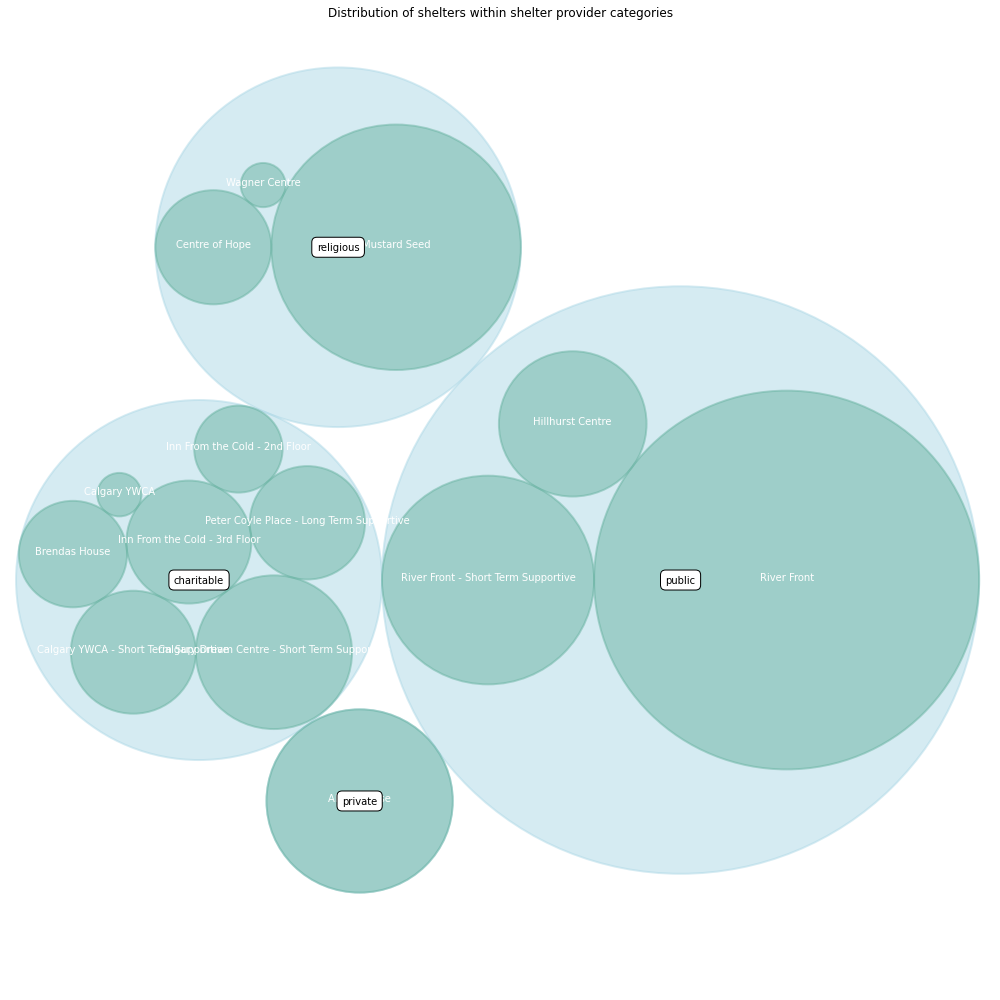

In [33]:
sh_cap = {
    x: y for (x,y) in zip(categories_df["ShelterName"], categories_df["Capacitya"])
}

type_sh = {
    x: list(categories_df.loc[categories_df["organization_category"] == x, "ShelterName"])
    for x in categories_df["organization_category"].unique()
}

city_type = {
    "Calgary": {x: {} for x in list(categories_df["organization_category"].unique())}
}
for x in city_type["Calgary"]:
    city_type["Calgary"][x] = type_sh[x]


for city in city_type:
    for t in city_type[city]:
        city_type[city][t] = {x: sh_cap[x] for x in sh_cap if x in city_type[city][t]}

print(city_type)

out = {}

for city in city_type:
    out["id"] = city
    out["datum"] = 2278.0
    out["children"] = []
    
total_cap = {
    "private": 120.0,
    "charitable": 463.0,
    "religious": 462.0,
    "public": 1233.0
}
    
for city in city_type:
    # for t in city_type[city]:
    out["children"] = [
        {"id": t, "datum": total_cap[t], 
         "children": [
             {"id": key, "datum": val}
             for key, val in city_type[city][t].items()
         ]}
        for t in city_type[city]
    ]

out = [out]

# import the circlify library
import circlify

# Compute circle positions thanks to the circlify() function
circles = circlify.circlify(
    out, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(14,14))

# Title
ax.set_title('Distribution of shelters within shelter provider categories')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Print circle the highest level (continents):
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightblue"))

# Print circle and labels for the highest level:
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#69b3a2"))
    plt.annotate(label, (x,y ), ha='center', color="white")

# Print labels for the continents
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))
plt.show()

Based on website information of each shelter provider four categories of shelters could be recognized.
* Public - sponsored by the Goverment of Alberta,
* Private - did not contain Registered Canadian Charity number on their website,
* Charitable - did contain Registered Canadian Charity number on their website but are not affiliated with a religious organization,
* Religious - are charitable and are affiliated with a religious organization.

In [86]:
shelter_df["organization_category"] = shelter_df["Organization"].map(
    lambda x: org_type[x]
)
shelter_df["occupation_rate"] = shelter_df["Overnight"] / shelter_df["Capacity"]
shelter_df = shelter_df.loc[:, ["organization_category", "occupation_rate", "Capacity"]]

In [92]:
shelter_df = shelter_df.reset_index()
shelter_df["year"] = shelter_df["Date"].dt.year
shelter_df["month"] = shelter_df["Date"].dt.month
display(shelter_df)

,index,Date,organization_category,occupation_rate,Capacity,year,month
0,0,2013-04-01,public,0.965517,725,2013,4
1,1,2013-04-01,public,0.642857,140,2013,4
2,2,2013-04-01,public,0.970370,270,2013,4
3,3,2013-04-01,public,0.936000,125,2013,4
4,4,2013-04-01,religious,0.521739,23,2013,4
...,...,...,...,...,...,...,...
52817,52817,2022-06-30,charitable,0.000000,4,2022,6
52818,52818,2022-06-30,charitable,0.816667,60,2022,6
52819,52819,2022-06-30,charitable,1.325000,40,2022,6
52820,52820,2022-06-30,public,0.428016,1028,2022,6


In [93]:
categories_df=shelter_df.loc[(shelter_df["year"]==2019) & (shelter_df["month"]==12)]
display(categories_df)

,index,Date,organization_category,occupation_rate,Capacity,year,month
36067,36067,2019-12-01,public,0.765882,850,2019,12
36068,36068,2019-12-01,public,0.236434,258,2019,12
36069,36069,2019-12-01,public,0.000000,125,2019,12
36070,36070,2019-12-01,religious,0.583333,12,2019,12
36071,36071,2019-12-01,religious,0.887500,80,2019,12
...,...,...,...,...,...,...,...
36496,36496,2019-12-31,charitable,0.937500,80,2019,12
36497,36497,2019-12-31,charitable,1.000000,68,2019,12
36498,36498,2019-12-31,charitable,0.562500,80,2019,12
36499,36499,2019-12-31,charitable,0.000000,40,2019,12


#### Data Visualisation

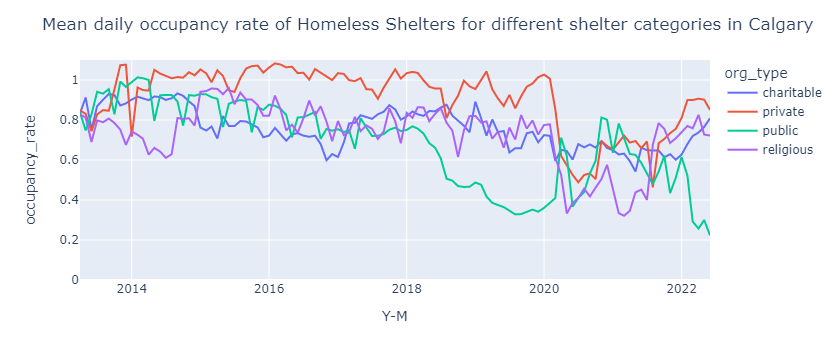

,year,month,charitable,private,public,religious,Y-M
0,2013,4,0.832733,0.847454,0.837954,0.828436,2013-04-01
1,2013,5,0.912724,0.830750,0.748039,0.812225,2013-05-01
2,2013,6,0.751753,0.743723,0.826999,0.690183,2013-06-01
3,2013,7,0.869081,0.827817,0.940880,0.797886,2013-07-01
4,2013,8,0.901113,0.849393,0.931781,0.788934,2013-08-01
...,...,...,...,...,...,...,...
106,2022,2,0.679706,0.900298,0.521443,0.770229,2022-02-01
107,2022,3,0.720176,0.899731,0.291888,0.758096,2022-03-01
108,2022,4,0.737180,0.906667,0.257259,0.825552,2022-04-01
109,2022,5,0.765222,0.901613,0.300160,0.727309,2022-05-01


In [89]:
mean_occ_by_category_df = (
    shelter_df.loc[:, ["year", "month", "organization_category", "occupation_rate"]]
    .groupby(["year", "month", "organization_category"])
    .mean("occupation_rate")
    .unstack()
)
mean_occ_by_category_df.columns = ["charitable", "private", "public", "religious"]
mean_occ_by_category_df
mean_occ_by_category_df = mean_occ_by_category_df.reset_index()
mean_occ_by_category_df["Y-M"] = pd.to_datetime(
    mean_occ_by_category_df["year"].astype("str")
    + "-"
    + mean_occ_by_category_df["month"].astype("str")
)
melted_mean_occ = pd.melt(
    mean_occ_by_category_df,
    id_vars=["year", "month"],
    var_name="org_type",
    value_vars=["charitable", "private", "public", "religious"],
    value_name="occupancy_rate",
)
melted_mean_occ = melted_mean_occ.astype({"year": "str", "month": "str"})
melted_mean_occ["Y-M"] = pd.to_datetime(
    melted_mean_occ[["year", "month"]].agg("-".join, axis=1)
)

fig = px.line(
    melted_mean_occ,
    x="Y-M",
    y="occupancy_rate",
    animation_group="org_type",
    color="org_type",
    hover_name="org_type",
    range_y=[0, 1.1],
)

fig.update_layout(
    autosize=True,
    title="Mean daily occupancy rate of Homeless Shelters for different shelter categories in Calgary",
)
fig.show()

display(mean_occ_by_category_df)

Based on the above, the occupancy rate is the highest for the private sector, often exceeding 1, while other providers oscillate around 0.8. For the public sector there is a drop in occupancy rate between 2018 and 2020. In 2020 there is a drop to 40-45% in occupancy rate in the religious and private which had an 80-100% occupancy rate before 2020,  with a simultaneous increase in the public sector from below 40% to 80%.

Capacity                                
organization_category charitable private      public   religious
year month                                                      
2013 4                 75.000000    94.0  315.000000  150.500000
     5                 79.166667   154.0  315.000000  184.000000
     6                 79.166667   154.0  373.333333  184.000000
     7                 79.166667   154.0  373.333333  184.000000
     8                 79.166667   154.0  373.333333  184.000000
...                          ...     ...         ...         ...
2022 2                 58.555556   120.0  240.666667  145.000000
     3                 58.555556   120.0  427.597403  210.416667
     4                 58.555556   120.0  517.500000  225.000000
     5                 58.555556   120.0  517.500000  201.342857
     6                 56.442688   120.0  517.500000  156.000000

[111 rows x 4 columns]

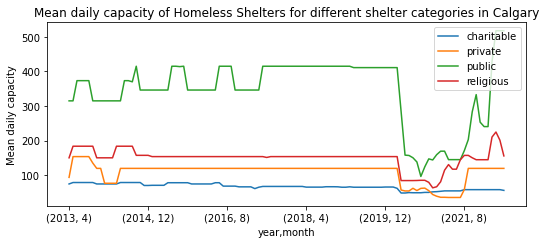

In [91]:
mean_cap_by_category_df = (
    shelter_df.loc[:, ["year", "month", "organization_category", "Capacity"]]
    .groupby(["year", "month", "organization_category"])
    .mean("Capacity")
    .unstack()
)

mean_cap_by_category_df.columns = ["charitable", "private", "public", "religious"]
mean_cap_by_category_df.plot()
plt.ylabel("Mean daily capacity")
plt.title(
    "Mean daily capacity of Homeless Shelters for different shelter categories in Calgary"
)
plt.show()


Based on the above, the average daily capacity for each month is the highest for the public sector. Again, we can clearly see the drop of capacity at the start of the pandemic which recovered after 1.5 years. This drop in capacity, especially significant in the public sector, contributes to the increase its occupancy rate.

In [ ]:
data = [{'id': 'Worl', 'datum': 6964195249, 'children' : [
              {'id' : "North America", 'datum': 450448697,
                   'children' : [
                     {'id' : "United States", 'datum' : 308865000},
                     {'id' : "Mexico", 'datum' : 107550697},
                     {'id' : "Canada", 'datum' : 34033000} 
                   ]},
              {'id' : "South America", 'datum' : 278095425, 
                   'children' : [
                     {'id' : "Brazil", 'datum' : 192612000},
                     {'id' : "Colombia", 'datum' : 45349000},
                     {'id' : "Argentina", 'datum' : 40134425}
                   ]},
              {'id' : "Europe", 'datum' : 209246682,  
                   'children' : [
                     {'id' : "Germany", 'datum' : 81757600},
                     {'id' : "France", 'datum' : 65447374},
                     {'id' : "United Kingdom", 'datum' : 62041708}
                   ]},
              {'id' : "Africa", 'datum' : 311929000,  
                   'children' : [
                     {'id' : "Nigeria", 'datum' : 154729000},
                     {'id' : "Ethiopia", 'datum' : 79221000},
                     {'id' : "Egypt", 'datum' : 77979000}
                   ]},
              {'id' : "Asia", 'datum' : 2745929500,  
                   'children' : [
                     {'id' : "China", 'datum' : 1336335000},
                     {'id' : "India", 'datum' : 1178225000},
                     {'id' : "Indonesia", 'datum' : 231369500}
                   ]}
    ]}]

## Problem 3 - Macroeconomic Indicators (Alberta): Weekly actual Income (measured once a month); Unemployment Rate (monthly data) 

#### Importance: How large is the impact of the economic state on homelessness? What is the time lag?  
#### Guiding Questions:
* Does the Rate of Occupancy of Homeless Shelters in Calgary depend on the state of the economy and how strong is the relationship? Is there a trend?                                                             
* Is there a time lapse between the change of economic indicators and the shelter occupancy? How big is the time lapse?    


In [9]:
fileS = "data/2013-2022-emergency-shelter-occupancy-machine-readable.csv"
fileE = "data/avg_weekly_earnings.csv"
fileU = "data/unemployment_rate.csv"

shdf = pd.read_csv(fileS, parse_dates=["Date"])
edf = pd.read_csv(fileE, parse_dates=["When"])
udf = pd.read_csv(fileU, parse_dates=["When"])

C:\Users\Testing5\AppData\Local\Temp\ipykernel_7312\2623877826.py:5: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  shdf = pd.read_csv(fileS, parse_dates=["Date"])


In [10]:
shdf.loc[
    (shdf["Date"] == "2022-04-01") & (shdf["ShelterName"] == "Brendas House"),
    "Capacity",
] = 60

shdf["Y-M"] = shdf["Date"].dt.to_period("M")
shdf = shdf.loc[
    (shdf["City"] == "Calgary")
    & (shdf["Date"] >= "2013-04-01")
    & (shdf["Date"] < "2020-01-01"),
    ["Y-M", "Capacity", "Overnight"],
]

shdf = shdf.astype({"Capacity": "int32", "Overnight": "int32"})
shdf = shdf.groupby("Y-M").sum(["Capacity", "Overnight"])
shdf["Rate"] = shdf["Overnight"] / shdf["Capacity"]

#### Data wrangling for the shelter data:
* Filter out the occupancy shelter data frame to only have Calgary data.
* Manually fill the one missing value based on the initial anaysis (2022-04-01, Capacity of Brendas House is filled based on its Capacity in the previous and later days. It stays at the same level for the previous three and the next three days).
* Created new column that keeps monthly granuality ("Y-M"), limited data to the time range from 2013-04-01 to 2020-01-01.
* Convert Capacity and Overnight (Admissions) columns to integer.
* Groupped the data by month and summed up Capacity and Overnight for all shelters.
* Compute the Occupancy Rates by dividing the summed up Overnight Admissions by the summed up Capacity.

In [11]:
udf = udf.loc[(udf["When"] >= "2013-04-01") & (udf["When"] < "2020-01-01")]
udf = udf.loc[
    (udf["NAICS"] == "All Industries")
    & (udf["Sex"] == "Both sexes")
    & (udf["AgeGroup"] == "15 years and over"),
    ["When", "Alberta"],
]
udf = udf.rename(columns={"When": "Date", "Alberta": "Unemployment AB"}, errors="raise")
udf["Y-M"] = udf["Date"].dt.to_period("M")
udf = udf[["Y-M", "Unemployment AB"]]

* Filter out the data frame to only have Calgary data.
* Limited data to the time range from 2013-04-01 to 2020-01-01, chose data "All industries", for both sexes, 15 years and over.
* Kept two columns: "When" (Date) and "Alberta" and renamed them to: "Date", "Unemployment AB" repsectively.
* Created new column that keeps monthly granuality ("Y-M")

In [13]:
edf = edf.loc[
    (edf["When"] >= "2013-04-01") & (edf["When"] < "2020-01-01")
    & (edf["NAICS"] == "Industrial aggregate excluding unclassified businesses"),
    ["When", "Alberta"],
]

edf["Y-M"] = edf["When"].dt.to_period("M")
edf = edf.rename(columns={"Alberta": "Weekly Wages AB"})
edf = edf[["Y-M", "Weekly Wages AB"]]

* Filter out the data frame to only have Calgary data.
* Limited data to the time range from 2013-04-01 to 2020-01-01, chose data "Industrial aggregate excluding unclassified businesses".
* Kept two columns: "When" (Date) and "Alberta" and renamed them to: "Date", "Unemployment AB" repsectively.
* Created new column that keeps monthly granuality ("Y-M")

In [15]:
a2 = shdf.join(udf.set_index("Y-M"), on="Y-M", how="inner")

In [29]:
joined_shelter_economic_df = a2.join(edf.set_index("Y-M"), on="Y-M", how="inner")
joined_shelter_economic_df = joined_shelter_economic_df.reset_index()

#### Data Visualisation

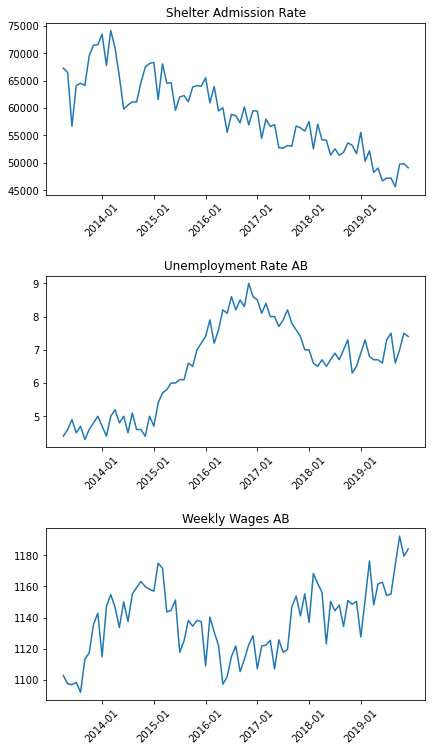

In [30]:
fig, ax=plt.subplots(3,1, figsize=(6,10))
fig.tight_layout(h_pad=6)
ax[0].plot(joined_shelter_economic_df["Y-M"].astype("str"), joined_shelter_economic_df["Overnight"])
ax[0].set_xticks(joined_shelter_economic_df["Y-M"].astype("str")[9::12], rotation=45)
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_title("Shelter Admission Rate")
ax[1].plot(joined_shelter_economic_df["Y-M"].astype("str"), joined_shelter_economic_df["Unemployment AB"])
ax[1].set_xticks(joined_shelter_economic_df["Y-M"].astype("str")[9::12])
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_title("Unemployment Rate AB")
ax[2].plot(joined_shelter_economic_df["Y-M"].astype("str"), joined_shelter_economic_df["Weekly Wages AB"])
ax[2].set_xticks(joined_shelter_economic_df["Y-M"].astype("str")[9::12])
ax[2].tick_params(axis='x', labelrotation=45)
ax[2].set_title("Weekly Wages AB")
plt.show()

The above time series graphs present the change over time of the monthly admissions to homeless shelters in clagary, Monthly unemployment rate, and weekly wages. Form the graphs it appears than there may be a negative correlation between unemployment rate and admissions to homeless shelters and negative correlation between average per month weekly wages and admissions to homeless shelters.

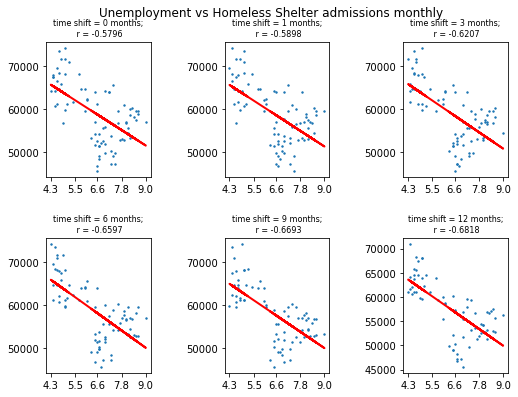

In [31]:
shifts = [0, 1, 3, 6, 9, 12]
for i in shifts:
    joined_shelter_economic_df[f"shift_{i}"] = joined_shelter_economic_df["Overnight"].shift(-i)

nrows = 2
ncols = 3

fig, ax = plt.subplots(2, 3, figsize=(8, 6))
fig.tight_layout(pad=4.0)

i = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row, col].scatter(joined_shelter_economic_df["Unemployment AB"], joined_shelter_economic_df[f"shift_{shifts[i]}"], s=2)

        b, a = np.polyfit(
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Unemployment AB"],
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), f"shift_{shifts[i]}"],
            deg=1,
        )
        ax[row, col].plot(
            joined_shelter_economic_df["Unemployment AB"],
            b * joined_shelter_economic_df["Unemployment AB"] + a,
            linewidth=2,
            color="red",
        )
        r = stats.pearsonr(
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Unemployment AB"],
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), f"shift_{shifts[i]}"],
        )[0]
        ax[row, col].set_title(
            f"time shift = {shifts[i]} months;\n r = {round(r, 4)}", size=8
        )
        ax[row, col].set_xticks(
            [
                round(x, 1)
                for x in np.linspace(
                    joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Unemployment AB"].min(),
                    joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Unemployment AB"].max(),
                    5,
                )
            ]
        )
        i += 1

fig.suptitle("Unemployment vs Homeless Shelter admissions monthly")
plt.show()

The above scatter plots of lagged unemployment rate v.s homeless shelter admissions display negative correlation between the two variable, indicating the trend opposite to expected from the economic theory - increased homelessness due increse in unemployment. Further invesigation is required, i.e. analysis of additional data and policies to explain this surprising outome. The negative correlation is maintained for all the monthly time-lags for 0, 1, 3, 6, 9, and 12 months. The next graph depicts the strength of such correlation for up to 24 monthly lags.


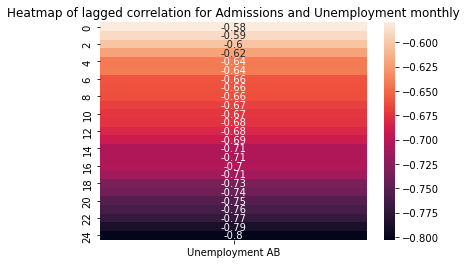

In [32]:
for i in range(25):
    joined_shelter_economic_df[f"overnight_{i}"] = joined_shelter_economic_df["Overnight"].shift(-i)

tmp = joined_shelter_economic_df.loc[:, [f"overnight_{i}" for i in range(0, 25)] + ["Unemployment AB"]]
corrs = tmp.corr()[["Unemployment AB"]][:-1].reset_index()[["Unemployment AB"]]
sns.heatmap(corrs, annot=True).set(title="Heatmap of lagged correlation for Admissions and Unemployment monthly")
plt.show()

The negative correlation between lagged unemployment rate and monthly admissions to homeless shelters increases in strength with the increase of the time lag, meaning that the earlier in time unemployment rate has greater explained influence on the admissions to homeless shelters. Further ivesitgation is required to explain this phenomenon (i.e. additional variables, changes in government policies and social programs). The relationship is not necessirily a cause-effect relatonship.

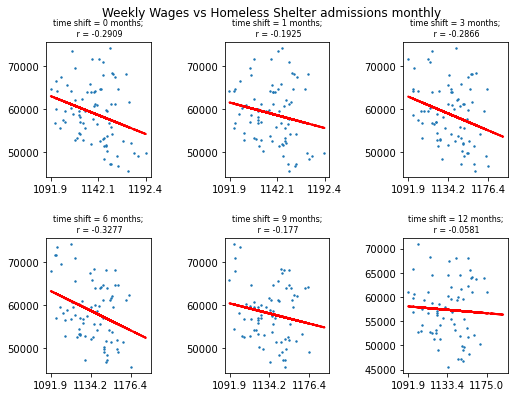

In [33]:
shifts = [0, 1, 3, 6, 9, 12]
for i in shifts:
    joined_shelter_economic_df[f"shift_{i}"] = joined_shelter_economic_df["Overnight"].shift(-i)

nrows = 2
ncols = 3

fig, ax = plt.subplots(2, 3, figsize=(8, 6))
fig.tight_layout(pad=4.0)

i = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row, col].scatter(joined_shelter_economic_df["Weekly Wages AB"], joined_shelter_economic_df[f"shift_{shifts[i]}"], s=2)

        b, a = np.polyfit(
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Weekly Wages AB"],
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), f"shift_{shifts[i]}"],
            deg=1,
        )
        ax[row, col].plot(
            joined_shelter_economic_df["Weekly Wages AB"],
            b * joined_shelter_economic_df["Weekly Wages AB"] + a,
            linewidth=2,
            color="red",
        )
        r = stats.pearsonr(
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Weekly Wages AB"],
            joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), f"shift_{shifts[i]}"],
        )[0]
        ax[row, col].set_title(
            f"time shift = {shifts[i]} months;\n r = {round(r, 4)}", size=8
        )
        ax[row, col].set_xticks(
            [
                round(x, 1)
                for x in np.linspace(
                    joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Weekly Wages AB"].min(),
                    joined_shelter_economic_df.loc[~joined_shelter_economic_df[f"shift_{shifts[i]}"].isna(), "Weekly Wages AB"].max(),
                    3,
                )
            ]
        )
        i += 1

fig.suptitle("Weekly Wages vs Homeless Shelter admissions monthly")
plt.show()

The negative correlation, as shown on the graphs above, between weekly wages and admissions to homeless shelters is rather expected. The change of its strength with lag is presented on the next heat map plot.

[Text(0.5, 1.0, 'Heatmap of lagged correlation for Admissions and Weekly Wages monthly')]

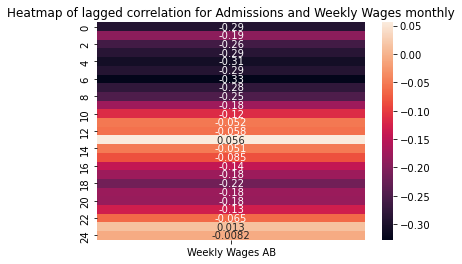

In [34]:
tmp = joined_shelter_economic_df.loc[:, [f"overnight_{i}" for i in range(0, 25)] + ["Weekly Wages AB"]]
corrs = tmp.corr()[["Weekly Wages AB"]][:-1].reset_index()[["Weekly Wages AB"]]
sns.heatmap(corrs, annot=True).set(title="Heatmap of lagged correlation for Admissions and Weekly Wages monthly")

The maximum value of the lagged correlation is obtained at lag 6. There is a repetitve pattern of period of length 12 months, which may be due to seasonaliy. As the lag increases, the correlation weakens.

## Problem 4 - Weather (Calgary): Temperature, Precipitation

#### Importance: Knowing how the weather influences occupancy helps determine the number of available beds.  
#### Guiding Questions:
* Does the Rate of Occupation of Homeless Shelters in Calgary depend on the weather (temp.& precip) and how strong is the relationship? Is there a trend?
* Which factor is more significant: temperature or precipitation? 
* Is there a time lapse between the change of the weather and the shelter occupancy? How big is the time lapse? 

#### Data wrangling for the shelter data:
* Filter out the occupancy shelter data frame to only have Calgary data.
* Manually fill the one missing value based on the initial anaysis (2022-04-01, Capacity of Brendas House is filled based on its Capacity in the previous and later days. It stays at the same level for the previous three and the next three days).
* Convert Capacity and Overnight (Admissions) columns to integer.
* Group the data by day and sum up Capacity and Overnight for all shelters.
* Compute the Occupancy Rates by dividing the summed up Overnight Admissions by the summed up Capacity.

In [62]:
shelter_df = pd.read_csv(
    "data/2013-2022-emergency-shelter-occupancy-machine-readable.csv",
    parse_dates=["Date"],
)

# manually add the missing value for the Brenda House 2022-04-01 capacity
shelter_df.loc[
    (shelter_df["Date"] == "2022-04-01")
    & (shelter_df["ShelterName"] == "Brendas House"),
    "Capacity",
] = 60

shelter_df = shelter_df.loc[
    shelter_df["City"] == "Calgary",
    ["City", "Date", "ShelterName", "Capacity", "Overnight", "ShelterType"],
]
shelter_df = shelter_df.astype({"Capacity": "int32", "Overnight": "int32"})
shelter_df = shelter_df.groupby("Date").sum(["Capacity", "Overnight"])
shelter_df["occupancy_rate"] = shelter_df["Overnight"] / shelter_df["Capacity"]

C:\Users\Testing5\AppData\Local\Temp\ipykernel_7312\753325494.py:1: DtypeWarning:

Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.



#### Data wrangling for the weather data:
* Filter out the occupancy shelter data frame to only have `Township = T024R01W5` data (this is the township that contains downtown Calgary).
* Since there is no missing data, we do not need to to any typy conversions for the weather metrics.
* After both dataframes are prepared, they are joined together based on the date.
* Filter the data to only contain year 2019

In [63]:
weather_df = pd.read_csv("data/weather_data.csv", parse_dates=["Date"])
columns_to_keep = list(weather_df.columns)
columns_to_keep.pop(0)
weather_df = weather_df.loc[weather_df["Township"] == "T024R01W5", columns_to_keep]
weather_df = weather_df.set_index("Date")

In [64]:
joined_df = weather_df.join(shelter_df, how="inner")

weather_occupancy_df = joined_df.reset_index()
weather_occupancy_df = weather_occupancy_df.loc[
    weather_occupancy_df["Date"].dt.year.isin([2019, 2021]),
    ["Precip. (mm)", "Air Temp. Min. (°C)", "occupancy_rate", "Date"],
]

#### Data Visualisation

In [65]:
# data preparation for multiple group plots
air_temp_df = weather_occupancy_df.loc[
    :, ["Air Temp. Min. (°C)", "Precip. (mm)", "occupancy_rate", "Date"]
]
air_temp_df["YEAR"] = air_temp_df["Date"].dt.year
# air_temp_df = air_temp_df.set_index("YEAR")
air_temp_df = pd.concat(
    [
        air_temp_df.loc[air_temp_df["YEAR"] == 2019].reset_index(),
        air_temp_df.loc[air_temp_df["YEAR"] == 2021].reset_index(),
    ],
    axis=1,
)
# change the column names to keep the names distinct
air_temp_df.columns.values[1] = "Air Temp. Min. (°C) 2019"
air_temp_df.columns.values[2] = "Precip. (mm) 2019"
air_temp_df.columns.values[3] = "occupancy_rate 2019"
air_temp_df.columns.values[7] = "Air Temp. Min. (°C) 2021"
air_temp_df.columns.values[8] = "Precip. (mm) 2021"
air_temp_df.columns.values[9] = "occupancy_rate 2021"

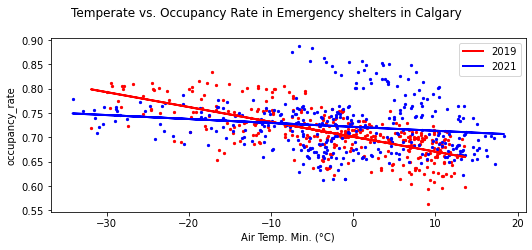

In [66]:
# scatter with fitted lines
reg_2019 = linear_model.LinearRegression()
reg_2019.fit(
    np.array(air_temp_df["Air Temp. Min. (°C) 2019"]).reshape(-1, 1),
    air_temp_df["occupancy_rate 2019"],
)
slope_2019 = reg_2019.coef_[0]
intercept_2019 = reg_2019.intercept_

reg_2021 = linear_model.LinearRegression()
reg_2021.fit(
    np.array(air_temp_df["Air Temp. Min. (°C) 2021"]).reshape(-1, 1),
    air_temp_df["occupancy_rate 2021"],
)
slope_2021 = reg_2021.coef_[0]
intercept_2021 = reg_2021.intercept_

fig, ax = plt.subplots(1)
fig.suptitle("Temperate vs. Occupancy Rate in Emergency shelters in Calgary")

ax.plot(
    air_temp_df["Air Temp. Min. (°C) 2019"],
    slope_2019 * air_temp_df["Air Temp. Min. (°C) 2019"] + intercept_2019,
    linewidth=2,
    color="red",
    label="2019",
)
ax.plot(
    air_temp_df["Air Temp. Min. (°C) 2021"],
    slope_2021 * air_temp_df["Air Temp. Min. (°C) 2021"] + intercept_2021,
    linewidth=2,
    color="blue",
    label="2021",
)
ax.scatter(
    air_temp_df["Air Temp. Min. (°C) 2019"],
    air_temp_df["occupancy_rate 2019"],
    s=5,
    c="red",
)
ax.scatter(
    air_temp_df["Air Temp. Min. (°C) 2021"],
    air_temp_df["occupancy_rate 2021"],
    s=5,
    c="blue",
)
ax.set_ylabel("occupancy_rate")
ax.set_xlabel("Air Temp. Min. (°C)")
plt.legend()

Based on the graph above, we can see that the correlation of the minimum temperature and the occupancy rate is stronger in 2019 (pre-pandemic) than that in 2021 (during pandemic). In both cases, the linear correlation is negative. There is a cluster of observations from 2021 inconsistent with the remaining data of that year depicting relatively high occupancy rates for warmer temepratures. Suspected reason is the impact of COVID-19 pandemic.

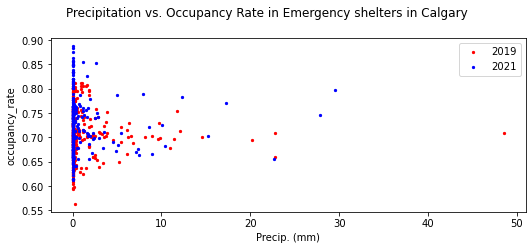

In [71]:
fig, ax = plt.subplots(1)
fig.suptitle("Precipitation vs. Occupancy Rate in Emergency shelters in Calgary")

ax.scatter(
    air_temp_df["Precip. (mm) 2019"],
    air_temp_df["occupancy_rate 2019"],
    s=5,
    c="red",
    label="2019",
)
ax.scatter(
    air_temp_df["Precip. (mm) 2021"],
    air_temp_df["occupancy_rate 2021"],
    s=5,
    c="blue",
    label="2021",
)
ax.set_ylabel("occupancy_rate")
ax.set_xlabel("Precip. (mm)")
plt.legend()
plt.show()

Looking at this plot, it can be clearly seen that the right skewness of the precipitation makes the graph unreadable. For better clarity the subsequent graph omits non-precipitation days.

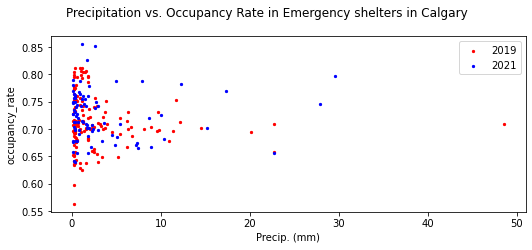

In [72]:
fig, ax = plt.subplots(1)
fig.suptitle("Precipitation vs. Occupancy Rate in Emergency shelters in Calgary")

ax.scatter(
    air_temp_df.loc[air_temp_df["Precip. (mm) 2019"] > 0, "Precip. (mm) 2019"],
    air_temp_df.loc[air_temp_df["Precip. (mm) 2019"] > 0, "occupancy_rate 2019"],
    s=5,
    c="red",
    label="2019",
)
ax.scatter(
    air_temp_df.loc[air_temp_df["Precip. (mm) 2021"] > 0, "Precip. (mm) 2021"],
    air_temp_df.loc[air_temp_df["Precip. (mm) 2021"] > 0, "occupancy_rate 2021"],
    s=5,
    c="blue",
    label="2021",
)
ax.set_ylabel("occupancy_rate")
ax.set_xlabel("Precip. (mm)")
plt.legend()
plt.show()

Even with non-precipitation data removed, there is no correlation between precipitation and occupancy rates. One of the reasons might be that normally, there is very little precipitation in the city of Calgary across the year.

In [76]:
slopes = []
intercepts = []

weather_occupancy_df = weather_occupancy_df.loc[
    weather_occupancy_df["Date"].dt.year == 2019,
    ["Precip. (mm)", "Air Temp. Min. (°C)", "occupancy_rate", "Date"],
]
days= [0, 1, 3, 7]
for i in days:
    weather_occupancy_df[f"shift_{i}"] = weather_occupancy_df["occupancy_rate"].shift(i)

    reg = linear_model.LinearRegression()
    reg.fit(
        np.array(weather_occupancy_df["Air Temp. Min. (°C)"]).reshape(-1, 1)[i:],
        weather_occupancy_df[f"shift_{i}"][i:],
    )
    slopes.append(reg.coef_[0])
    intercepts.append(reg.intercept_)

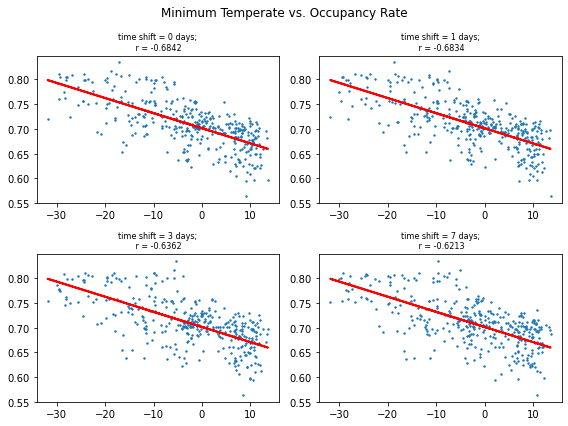

In [78]:
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows, ncols, figsize=(8, 6))
fig.tight_layout(pad=4.0)

i = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].scatter(
            weather_occupancy_df["Air Temp. Min. (°C)"], weather_occupancy_df[f"shift_{days[i]}"], s=2
        )
        ax[row,col].plot(
            weather_occupancy_df["Air Temp. Min. (°C)"],
            slopes[0] * weather_occupancy_df["Air Temp. Min. (°C)"] + intercepts[0],
            linewidth=2,
            color="red",
        )
        r = stats.pearsonr(
            weather_occupancy_df.loc[~weather_occupancy_df[f"shift_{days[i]}"].isna(), f"shift_{days[i]}"],
            weather_occupancy_df.loc[
                ~weather_occupancy_df[f"shift_{days[i]}"].isna(), f"Air Temp. Min. (°C)"
            ],
        )[0]
        ax[row,col].set_title(f"time shift = {days[i]} days;\n r = {round(r, 4)}", size=8)
        i+=1

fig.suptitle("Minimum Temperate vs. Occupancy Rate")
plt.show()

The above analysis of the shift in days between the occupation rate and the minimum temperature seems to indicate that there is no time lag between change in weather and shelter occupancy rates.

## Problem 5 - Crime Rate by region of the City of Calgary 

#### Importance: Knowing whether the location of the homeless shelters correlates with the level of crime rate in the area. Knowing whether and how far from the homeless shelter crimes are committed. 
#### Guiding Questions:
* Do the Crime Rate and the Rate of Occupancy of Homeless Shelters in Calgary (by regions of Calgary and locations of homeless shelters) correlate? 

#### Data wrangling for the shelter data:
* Filter out the occupancy shelter data frame to only have Calgary data.
* Manually fill the one missing value based on the initial anaysis (2022-04-01, Capacity of Brendas House is filled based on its Capacity in the previous and later days. It stays at the same level for the previous three and the next three days).
* Convert Capacity and Overnight (Admissions) columns to integer.
* Filter to only have the data after 2017-01-01 and non-negative Capacity.
* Group the data by Quarter and Sheter Name and sum up Capacity and Overnight for all shelters.
* Compute the Occupancy Rates by dividing the summed up Overnight Admissions by the summed up Capacity.

In [79]:
shelter_df = pd.read_csv(
    "data/2013-2022-emergency-shelter-occupancy-machine-readable.csv",
    parse_dates=["Date"],
)
# manually add the missing value for the Brenda House 2022-04-01 capacity
shelter_df.loc[
    (shelter_df["Date"] == "2022-04-01")
    & (shelter_df["ShelterName"] == "Brendas House"),
    "Capacity",
] = 60

shelter_df = shelter_df.loc[
    shelter_df["City"] == "Calgary",
    [
        "City",
        "Date",
        "ShelterName",
        "Capacity",
        "Overnight",
        "ShelterType",
        "YEAR",
        "MONTH",
    ],
].astype({"Capacity": "int32", "Overnight": "int32"})

shelter_df.loc[:, "QUARTER"] = shelter_df["Date"].dt.to_period("Q").astype("str")

shelter_df = (
    shelter_df.loc[shelter_df["Date"].dt.year >= 2017]
    .loc[shelter_df["Capacity"] > 0]
    .groupby(["QUARTER", "ShelterName"])
    .sum(["Capacity", "Overnight"])
    .reset_index()
    .set_index("ShelterName")
)

shelter_df["occupancy_rate"] = shelter_df["Overnight"] / shelter_df["Capacity"]

C:\Users\Testing5\AppData\Local\Temp\ipykernel_7312\1501515984.py:1: DtypeWarning:

Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.



#### Data wrangling for the crime data:
* Load the 2019 Census data for Calgary as GeoDataFrame
* Filter out the the regions whose names start with a number (those don't have any residents).
* Load the crime data (monthly).
* Similar to the previous load, filter out the regions with no residents and regions without the location.
* Group the data by Quarter and Community Name and sum up the Crime Count.
* Join crime data with the census data.
* Convert the joined data into GeoDataFrame

In [231]:
cen_df = gpd.read_file("data/census_by_community_2019.geojson")
communities_df = cen_df[["name", "geometry"]]
communities_df = communities_df.loc[
    ~communities_df["name"].str.contains("^\d")
].set_index("name")

In [232]:
crime_df = pd.read_csv("data/community_crime_statistics.csv", parse_dates=["Date"])
crime_df.loc[:, "QUARTER"] = crime_df.loc[:, "Date"].dt.to_period("Q").astype("str")
crime_df = (
    crime_df.loc[~crime_df["Community Name"].str.contains("^\d")]
    .loc[~crime_df["lat"].isna()]
    .groupby(["Community Name", "QUARTER"])
    .sum(["Crime Count"])["Crime Count"]
    .reset_index()
    .set_index("Community Name")
    .join(communities_df, how="right")
)

crime_gdf = gpd.GeoDataFrame(crime_df, geometry=crime_df["geometry"])
crime_gdf = crime_gdf.to_crs(epsg=4326)

#### Web scraping for the available homeless shelters addresses

This part makes use of the web-scraping library called BeautifulSoup. Based on the structure of the Government of Alberta website, we extracted the addresses for the homeless shelter.

BeautifulSoup setup:

In [233]:
user_agent = "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7"
url = "https://www.alberta.ca/find-shelters.aspx"
headers = {
    "User-Agent": user_agent,
}

request = urllib.request.Request(url, None, headers)
response = urllib.request.urlopen(request)
data = response.read()

shelter_soup = BeautifulSoup(data)

Based on the html structure of the website, we located the structure that keeps the address data.

In [234]:
calgary_shelters_start = shelter_soup.find(id="goa-grid11591").find(
    lambda tag: tag.name == "h3" and tag.string == "Calgary"
)

calgary_shelters_end = shelter_soup.find(id="goa-grid11591").find(
    lambda tag: tag.name == "h3" and tag.string == "Edmonton"
)

BeautifulSoup capabilities used to generate a dictiorary that maps the shelter name (read from the website) to the respective address.

In [235]:
shelters = []

for sib in calgary_shelters_start.next_siblings:
    if sib == calgary_shelters_end:
        break
    elif sib == "\n":
        continue
    shelters.append(sib)

shelter_names = [shelter.find("a", target="_blank").string for shelter in shelters]
shelter_addresses = [
    shelter.find(string=re.compile("^\n[\d]+|^\n[\w]+\s[\w]+,\s[\d]+"))
    for shelter in shelters
]
shelter_addresses = [str(s).strip().replace("\xa0", " ") for s in shelter_addresses]

shelters_dict = {
    name: address.split(",")[-1]
    for (name, address) in zip(shelter_names, shelter_addresses)
}
shelters_dict

{'Alpha House Shelter': '203 15 Avenue SE',
 'Brenda’s House': '1921 28 Street SW',
 'Calgary Drop-In & Rehab Centre': '1 Dermot Baldwin Way SE',
 'Inn From the Cold': '110 11 Avenue SE',
 'YW Calgary Emergency Shelter': '1715 17 Avenue SE',
 'Mustard Seed Foothills Shelter': '7025 44 Street SE',
 'Salvation Army Centre of Hope': '420 9 Avenue SE',
 'Salvation Army Women’s Integrated Supportive Housing (WISH)': ' 3013 15 Avenue SW'}

Based on the available shelters in the `crime_gdf` GeoDataFrame, we select only those that match the scraped addresses.

In [236]:
adjusted_names = [
    "Alpha House",
    "Brendas House",
    "CDIC - Days Inn Overflow",
    "Inn From the Cold - 3rd Floor",
    "Calgary YWCA",
    "Mustard Seed",
    "Centre of Hope",
    "daytime",
]

Adjusting the shelter names so that they match records kept in the `crime_gdf` GeoDataFrame.

In [237]:
adjusted_shelter_addresses = {}
for new_name, old_name in zip(adjusted_names, shelter_names):
    adjusted_shelter_addresses[new_name] = shelters_dict[old_name]

adjusted_shelter_addresses.pop("daytime", None)
adjusted_shelter_addresses

{'Alpha House': '203 15 Avenue SE',
 'Brendas House': '1921 28 Street SW',
 'CDIC - Days Inn Overflow': '1 Dermot Baldwin Way SE',
 'Inn From the Cold - 3rd Floor': '110 11 Avenue SE',
 'Calgary YWCA': '1715 17 Avenue SE',
 'Mustard Seed': '7025 44 Street SE',
 'Centre of Hope': '420 9 Avenue SE'}

Using the `geopy` functionality to create a data frame that contains the geographical coordinates of the shelters.

In [238]:
geolocator = Nominatim(user_agent="DATA_601_project")

shelter_location_df = pd.DataFrame(
    {
        "ShelterName": adjusted_shelter_addresses.keys(),
        "ShelterAddress": adjusted_shelter_addresses.values(),
    }
)
shelter_location_df["ShelterAddress"] = (
    shelter_location_df["ShelterAddress"] + " Calgary"
)
shelter_location_df["ShelterLongitude"] = shelter_location_df["ShelterAddress"].map(
    lambda x: geolocator.geocode(x).longitude
)
shelter_location_df["ShelterLatitude"] = shelter_location_df["ShelterAddress"].map(
    lambda x: geolocator.geocode(x).latitude
)
shelter_location_df = shelter_location_df.set_index("ShelterName")
shelter_location_df

,ShelterAddress,ShelterLongitude,ShelterLatitude
ShelterName,,,
Alpha House,203 15 Avenue SE Calgary,-114.060870,51.038311
Brendas House,1921 28 Street SW Calgary,-114.125440,50.971870
CDIC - Days Inn Overflow,1 Dermot Baldwin Way SE Calgary,-114.053858,51.048814
Inn From the Cold - 3rd Floor,110 11 Avenue SE Calgary,-114.053465,51.042092
Calgary YWCA,1715 17 Avenue SE Calgary,-113.989478,51.037845
Mustard Seed,7025 44 Street SE Calgary,-113.971351,50.993198
Centre of Hope,420 9 Avenue SE Calgary,-114.054317,51.044629


Joining both data frames together so that we end up with the geographical locations for the shelters.

In [239]:
shelter_df = shelter_df.join(shelter_location_df, how="inner")

Converting the data frame to GeoDataFrame and adding the columns that will be useful for the later visualization.

In [240]:
shelter_gdf = gpd.GeoDataFrame(
    shelter_df,
    geometry=gpd.points_from_xy(
        shelter_df.ShelterLongitude, shelter_df.ShelterLatitude
    ),
)
shelter_gdf.crs = "EPSG:4326"
shelter_gdf = shelter_gdf.sort_values("occupancy_rate")
shelter_gdf["color"] = (
    (255 - shelter_gdf["occupancy_rate"] * 255).astype("int64").clip(0, None)
)

#### Visualization

For this visualization, we create a number of traces that are set to be invisible.<br>
* There is one layer that displays the summed up crime count for a given quarter
* There is a separate layer for each homeless shelter with corresponding gray-scale color displaying the occupancy

As the slider is moved left or right, the traces that correspond to the the active quarter are set to be visible.

In [ ]:
fig = go.Figure()

slice_lengths = []
quarters = sorted(list(shelter_gdf["QUARTER"].unique()))
for quarter in quarters:
    crime_slice = crime_gdf.loc[crime_gdf["QUARTER"] == quarter]
    shelter_slice = shelter_gdf.loc[shelter_gdf["QUARTER"] == quarter]
    slice_lengths.append(1 + shelter_slice.shape[0])

    fig.add_trace(
        go.Choroplethmapbox(
            visible=False,
            geojson=json.loads(crime_slice.to_json()),
            locations=crime_slice.index,
            z=crime_slice["Crime Count"],
            zmin=0,
            zmax=651,
            colorscale="Oranges",
            marker_opacity=0.75,
            marker_line_width=0.5,
            name=quarter,
        )
    )

    for i in range(shelter_slice.shape[0]):
        c = f'rgb({shelter_slice["color"][i]}, {shelter_slice["color"][i]}, {shelter_slice["color"][i]})'
        fig.add_trace(
            go.Scattermapbox(
                visible=False,
                lat=[shelter_slice.geometry.iloc[i].y],
                lon=[shelter_slice.geometry.iloc[i].x],
                mode="markers",
                marker=go.scattermapbox.Marker(
                    size=15,
                    color=c,
                    opacity=0.9,
                ),
                line=dict(color="black", width=10),
                hoverinfo="all",
                name=f"{shelter_slice.index[i]} ({shelter_slice['occupancy_rate'][i]:.3f})",
            )
        )

steps = []
for i, slice in enumerate(slice_lengths):
    begin = sum(slice_lengths[:i])
    end = begin + slice
    step = dict(
        method="update",
        args=[
            {"visible": [False] * len(fig.data)},
            {"title": "YYC Crime Rate and Shelter Occupancy: " + quarters[i]},
        ],  # layout attribute
        label=quarters[i],
    )
    step["args"][0]["visible"][begin:end] = [True] * slice
    steps.append(step)

sliders = [
    dict(active=10, currentvalue={"prefix": "Quarter: "}, pad={"t": 50}, steps=steps)
]


fig.update_layout(
    margin={"r": 50, "t": 50, "l": 50, "b": 50},
    autosize=True,
    height=600,
    legend={"yanchor": "top", "y": 0.99, "xanchor": "left", "x": 0.01},
    mapbox_style="carto-positron",
    mapbox_center={"lat": 51.0486, "lon": -114.0708},  # Calgary
    mapbox_zoom=9,
    sliders=sliders,
    title="YYC Crime Rate and Shelter Occupancy",
)

for i in range(70, 77):
    fig.data[i].visible = True

fig.show()